In [ ]:
%pip install pymysql

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import os
import pymysql
import pandas as pd
import numpy as np

succeess = False

while not succeess:
  try:
    conn = pymysql.connect(
        host='db-aff.cpapv35x7rsh.us-east-2.rds.amazonaws.com',
        port=int(3306),
        user="admin",
        passwd="ds5110db",
        db='olist',
        charset='utf8mb4')
    db = conn.cursor()
    succeess = True
  except:
    print("Wrong Password")

print("Connection Made")


def add_quotes(s):
  return '"'+str(s)+'",'

def add_quotes_nocomma(s):
  return '"'+str(s)+'"'

     |████████████████████████████████| 43 kB 969 kB/s 
Connection Made


In [ ]:
table_names = pd.read_sql_query("select table_name from information_schema.tables where table_type='BASE TABLE' and table_schema='olist'", conn)
table_names

,TABLE_NAME
0,customers
1,order_details
2,orders
3,payments
4,product_categories
5,products
6,reviews
7,sellers


In [ ]:
# Customers table
customers_tbl = pd.read_sql_query("select * from olist.customers", conn)
# pd.read_sql_query("select count(customer_id) from olist.customers group by customer_id", conn)
# order_details
order_details_tbl = pd.read_sql_query("select * from olist.order_details", conn)
# order_details_tbl
# pd.read_sql_query("select * from olist.order_details where order_id in "\
# "(select order_id from olist.order_details group by order_id having count(order_id) > 1 order by order_id)", conn)
# pd.read_sql_query("select order_id from olist.order_details group by order_id having count(product_id) > 1 order by order_id", conn)
# pd.read_sql_query("select * from olist.order_details where order_id='002f98c0f7efd42638ed6100ca699b42'", conn)
# pd.read_sql_query("select * from olist.orders", conn)
# pd.read_sql_query("select count(distinct customer_id) from olist.orders", conn)
# pd.read_sql_query("select count(distinct order_id) from olist.orders", conn)

# Joining Orders and Reviews tables

In [ ]:
import time

In [ ]:
reviews_df = pd.read_sql_query("select * from olist.reviews", conn)[['review_id', 'order_id', 'score', 'message']]
orders_main_df = pd.read_sql_query("select * from olist.orders", conn).drop(columns=['customer_id', 'order_status'])
start = time.process_time()
reviews_orders_df = pd.merge(reviews_df, orders_main_df, how='inner', on='order_id')
print("Time taken for join:- ", time.process_time() - start)

Time taken for join:-  0.17548631499999878


# Part 1
### Converting **order_approved_at, order_delivered_carrier_date, order_delivered_customer_date** into date time columns

In [ ]:
reviews_orders_df.head()

,review_id,order_id,score,message,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0001239bc1de2e33cb583967c2ca4c67,fc046d7776171871436844218f817d7d,5,nan,2018-02-20 18:07:05,2018-02-20 18:20:44,2018-02-22 00:22:55,2018-03-19 14:34:39,2018-03-19
1,0001cc6860aeaf5b9017fe4131a52e62,d4665434b01caa9dc3e3e78b3eb3593e,5,nan,2018-06-18 05:22:00,2018-06-18 06:09:34,2018-06-18 13:43:00,2018-06-21 22:48:57,2018-07-13
2,00020c7512a52e92212f12d3e37513c0,e28abf2eb2f1fbcbdc2dd0cd9a561671,5,A entrega foi super rápida e o pendente é lind...,2018-04-17 21:54:15,2018-04-17 22:12:18,2018-04-18 19:24:41,2018-04-24 18:12:22,2018-05-10
3,00032b0141443497c898b3093690af51,04fb47576993a3cb0c12d4b25eab6e4e,5,nan,2017-05-25 12:53:25,2017-05-25 13:10:17,2017-05-26 10:13:23,2017-05-29 21:22:04,2017-06-07
4,00034d88989f9a4c393bdcaec301537f,5f358d797a49fe2f24352f73426215f6,5,nan,2017-08-10 14:01:14,2017-08-10 14:23:36,2017-08-10 20:05:38,2017-08-11 17:45:52,2017-08-23


## **Data Cleaning and Preprocessing** reviews_orders_df to remove NA values from orders table and converting them to datetime columns.
#### NA values exists in form of '0000-00-00 00:00:00'.

In [ ]:
navalue = reviews_orders_df.iloc[90, :]['order_delivered_customer_date']
cols = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']
indices = np.array([True] * reviews_orders_df.shape[0])
for col in cols:
  ix_here = reviews_orders_df[col].apply(lambda x: False if x == navalue else True)
  indices = indices & ix_here

final_df = reviews_orders_df[indices]
for col in cols:
  final_df.loc[:, col] = pd.to_datetime(final_df.loc[:, col])

print("NA value is :- ", navalue)
print("Number of data points containing NA values ", reviews_orders_df.shape[0] - final_df.shape[0])

NA value is :-  0000-00-00 00:00:00
Number of data points containing NA values  2880


#### Converting delivered carrier and customer date into 'date' columns.

In [ ]:
final_df['order_delivered_carrier_date'] = final_df['order_delivered_carrier_date'].apply(lambda x: x.date())
final_df['order_delivered_customer_date'] = final_df['order_delivered_customer_date'].apply(lambda x: x.date())

## **Feature Engineering** :
#### Generating **delivery_delay**, a new feature that says whether the order was delivered before the estimated delivery date or not.

In [ ]:
final_df.head()

,review_id,order_id,score,message,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,order_purchase_month
0,0001239bc1de2e33cb583967c2ca4c67,fc046d7776171871436844218f817d7d,5,nan,2018-02-20 18:07:05,2018-02-20 18:20:44,2018-02-22,2018-03-19,2018-03-19,False,2
1,0001cc6860aeaf5b9017fe4131a52e62,d4665434b01caa9dc3e3e78b3eb3593e,5,nan,2018-06-18 05:22:00,2018-06-18 06:09:34,2018-06-18,2018-06-21,2018-07-13,False,6
2,00020c7512a52e92212f12d3e37513c0,e28abf2eb2f1fbcbdc2dd0cd9a561671,5,A entrega foi super rápida e o pendente é lind...,2018-04-17 21:54:15,2018-04-17 22:12:18,2018-04-18,2018-04-24,2018-05-10,False,4
3,00032b0141443497c898b3093690af51,04fb47576993a3cb0c12d4b25eab6e4e,5,nan,2017-05-25 12:53:25,2017-05-25 13:10:17,2017-05-26,2017-05-29,2017-06-07,False,5
4,00034d88989f9a4c393bdcaec301537f,5f358d797a49fe2f24352f73426215f6,5,nan,2017-08-10 14:01:14,2017-08-10 14:23:36,2017-08-10,2017-08-11,2017-08-23,False,8


In [ ]:
final_df['delivery_delay'] = final_df['order_delivered_customer_date'] > final_df['order_estimated_delivery_date']
final_df['order_purchase_month'] = final_df['order_purchase_timestamp'].apply(lambda x: x.month)
target_feature = 'score'
final_df['review_sentiment'] = final_df[target_feature].apply(lambda x: 0 if (x < 4) else 1)

In [ ]:
final_df.head()

,review_id,order_id,score,message,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,order_purchase_month,review_sentiment
0,0001239bc1de2e33cb583967c2ca4c67,fc046d7776171871436844218f817d7d,5,nan,2018-02-20 18:07:05,2018-02-20 18:20:44,2018-02-22,2018-03-19,2018-03-19,False,2,1
1,0001cc6860aeaf5b9017fe4131a52e62,d4665434b01caa9dc3e3e78b3eb3593e,5,nan,2018-06-18 05:22:00,2018-06-18 06:09:34,2018-06-18,2018-06-21,2018-07-13,False,6,1
2,00020c7512a52e92212f12d3e37513c0,e28abf2eb2f1fbcbdc2dd0cd9a561671,5,A entrega foi super rápida e o pendente é lind...,2018-04-17 21:54:15,2018-04-17 22:12:18,2018-04-18,2018-04-24,2018-05-10,False,4,1
3,00032b0141443497c898b3093690af51,04fb47576993a3cb0c12d4b25eab6e4e,5,nan,2017-05-25 12:53:25,2017-05-25 13:10:17,2017-05-26,2017-05-29,2017-06-07,False,5,1
4,00034d88989f9a4c393bdcaec301537f,5f358d797a49fe2f24352f73426215f6,5,nan,2017-08-10 14:01:14,2017-08-10 14:23:36,2017-08-10,2017-08-11,2017-08-23,False,8,1


## **Data Visualization**

#### Visualizing significance of delivery_delay on review score using a bar plot.

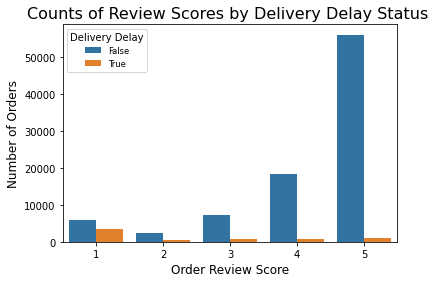

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x='score', hue='delivery_delay', data=final_df)
plt.xlabel('Order Review Score', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Counts of Review Scores by Delivery Delay Status ', fontsize=16)
plt.legend(title="Delivery Delay", fontsize='small', fancybox=True)
plt.savefig("review_score_by_delivery_delay.png")

### Obtaining final dataframe by joining order_item, payments with reviews and orders dataframe.

In [ ]:
final_df.shape

(96344, 12)

In [ ]:
orders_item_df = pd.read_sql_query("select * from olist.order_details", conn).drop(columns=['product_id', 'seller_id', 'qty'])
payments_df = pd.read_sql_query("select * from olist.payments", conn)
final_df = pd.merge(final_df, orders_item_df, left_on="order_id", right_on="order_id")
final_df = pd.merge(final_df, payments_df, left_on="order_id", right_on="order_id")

In [ ]:
final_df.head()

,review_id,order_id,score,message,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_delay,order_purchase_month,review_sentiment,shipping_limit_date,price,freight_value,payment_type,payment_installments,payment_total
0,0001239bc1de2e33cb583967c2ca4c67,fc046d7776171871436844218f817d7d,5,nan,2018-02-20 18:07:05,2018-02-20 18:20:44,2018-02-22,2018-03-19,2018-03-19,False,2,1,2018-02-28 18:20:44,145.00,15.76,credit_card,1,160.76
1,0001cc6860aeaf5b9017fe4131a52e62,d4665434b01caa9dc3e3e78b3eb3593e,5,nan,2018-06-18 05:22:00,2018-06-18 06:09:34,2018-06-18,2018-06-21,2018-07-13,False,6,1,2018-06-22 05:31:36,60.00,19.61,credit_card,1,79.61
2,00020c7512a52e92212f12d3e37513c0,e28abf2eb2f1fbcbdc2dd0cd9a561671,5,A entrega foi super rápida e o pendente é lind...,2018-04-17 21:54:15,2018-04-17 22:12:18,2018-04-18,2018-04-24,2018-05-10,False,4,1,2018-04-23 22:12:18,150.00,17.96,credit_card,1,167.96
3,00032b0141443497c898b3093690af51,04fb47576993a3cb0c12d4b25eab6e4e,5,nan,2017-05-25 12:53:25,2017-05-25 13:10:17,2017-05-26,2017-05-29,2017-06-07,False,5,1,2017-05-31 13:10:17,259.90,41.77,credit_card,1,301.67
4,00034d88989f9a4c393bdcaec301537f,5f358d797a49fe2f24352f73426215f6,5,nan,2017-08-10 14:01:14,2017-08-10 14:23:36,2017-08-10,2017-08-11,2017-08-23,False,8,1,2017-08-16 14:23:36,68.89,8.72,credit_card,1,77.61


## **Machine Learning**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelBinarizer

### Defining Input and Target features and data.

In [ ]:
final_df.columns.values

array(['review_id', 'order_id', 'score', 'message',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'delivery_delay',
       'order_purchase_month', 'review_sentiment', 'shipping_limit_date',
       'price', 'freight_value', 'payment_type', 'payment_installments',
       'payment_total'], dtype=object)

In [ ]:
LabelBinarizer().fit_transform(final_df['delivery_delay'].)

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0]])

In [ ]:
input_features = ['delivery_delay', 'price', 'freight_value', 'payment_type', 'payment_installments', 'order_purchase_month']
target_feature = 'review_sentiment'
x = final_df[input_features]
x['delivery_delay'] = LabelBinarizer().fit_transform(x['delivery_delay'])
x['payment_type'] = LabelBinarizer().fit_transform(x['payment_type'])
y = final_df[target_feature].values

In [ ]:
x.head()

,delivery_delay,price,freight_value,payment_type,payment_installments,order_purchase_month
0,0,145.00,15.76,0,1,2
1,0,60.00,19.61,0,1,6
2,0,150.00,17.96,0,1,4
3,0,259.90,41.77,0,1,5
4,0,68.89,8.72,0,1,8


###### Dividing dataframe into train and test data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=9)

### Using a **Random Forest Classifier** to predict sentiment of the reviews.

In [ ]:
ranfor = RandomForestClassifier().fit(x_train, y_train)

In [ ]:
features_imp_rf = pd.DataFrame({'feature_name': input_features, 'feature_importance': ranfor.feature_importances_})
features_imp_rf = features_imp_df.sort_values(by='feature_importance', ascending=True)

#### Plotting **Feature Importance** obtained from Random Forest Classifier.

Text(0.5, 1.0, 'Features Importance using Random Forest Classifier')

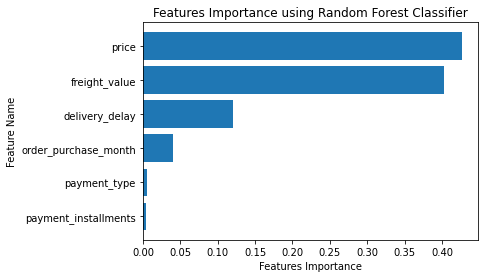

In [ ]:
plt.barh(y=features_imp_rf['feature_name'], width=features_imp_rf['feature_importance'])
plt.xlabel("Features Importance")
plt.ylabel("Feature Name")
plt.title("Features Importance using Random Forest Classifier")

#### **Loss and Accuracy metrics** for Random Forest Classifier

In [ ]:
train_acc_rf = metrics.accuracy_score(y_train, ranfor.predict(x_train))
test_acc_rf = metrics.accuracy_score(y_test, ranfor.predict(x_test))
train_ll_rf = metrics.log_loss(y_train, ranfor.predict_proba(x_train))
test_ll_rf = metrics.log_loss(y_test, ranfor.predict_proba(x_test))
train_f1_rf = metrics.f1_score(y_train, ranfor.predict(x_train))
test_f1_rf = metrics.f1_score(y_test, ranfor.predict(x_test))

In [ ]:
print("Training Log loss using Random Forest Classifier :- ", round(train_ll_rf, 5))
print("Test Log loss using Random Forest Classifier :- ", round(test_ll_rf, 5))
print("Train Accuracy using Random Forest Classifier :- ", round(train_acc_rf, 5))
print("Test Accuracy using Random Forest Classifier :- ", round(test_acc_rf, 5))
print("Train F1 Score using Random Forest Classifier :- ", round(train_f1_rf, 5))
print("Test F1 Score using Random Forest Classifier :- ", round(test_f1_rf, 5))

Training Log loss using Random Forest Classifier :-  0.17283
Test Log loss using Random Forest Classifier :-  0.94528
Train Accuracy using Random Forest Classifier :-  0.95195
Test Accuracy using Random Forest Classifier :-  0.77428
Train F1 Score using Random Forest Classifier :-  0.96978
Test F1 Score using Random Forest Classifier :-  0.86211


## Using **Logistic Regression** to predict sentiment of the reviews.

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression().fit(x_train, y_train)

In [ ]:
features_imp_lr = pd.DataFrame({'feature_name': input_features, 'feature_importance': logreg.coef_[0]})
features_imp_lr = features_imp_df.sort_values(by='feature_importance', ascending=True)

### **Features importance**, Coefficient of Correlation, using Logistic Regression

Text(0.5, 1.0, 'Features Importance using Logistic Regression')

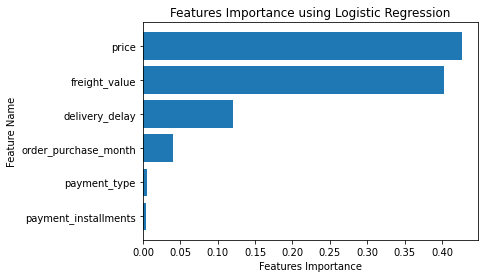

In [ ]:
plt.barh(y=features_imp_lr['feature_name'], width=features_imp_lr['feature_importance'])
plt.xlabel("Features Importance")
plt.ylabel("Feature Name")
plt.title("Features Importance using Logistic Regression")

### **Loss and Accuracy** metrics for Logistic Regression.

In [ ]:
train_acc_lr = metrics.accuracy_score(y_train, logreg.predict(x_train))
test_acc_lr = metrics.accuracy_score(y_test, logreg.predict(x_test))
train_ll_lr = metrics.log_loss(y_train, logreg.predict_proba(x_train))
test_ll_lr = metrics.log_loss(y_test, logreg.predict_proba(x_test))
train_f1_lr = metrics.f1_score(y_train, logreg.predict(x_train))
test_f1_lr = metrics.f1_score(y_test, logreg.predict(x_test))

In [ ]:
print("Training Log loss using Random Forest Classifier :- ", round(train_ll_lr, 5))
print("Test Log loss using Random Forest Classifier :- ", round(test_ll_lr, 5))
print("Train Accuracy using Random Forest Classifier :- ", round(train_acc_lr, 5))
print("Test Accuracy using Random Forest Classifier :- ", round(test_acc_lr, 5))
print("Train F1 Score using Random Forest Classifier :- ", round(train_f1_lr, 5))
print("Test F1 Score using Random Forest Classifier :- ", round(test_f1_lr, 5))

Training Log loss using Random Forest Classifier :-  0.4841
Test Log loss using Random Forest Classifier :-  0.48313
Train Accuracy using Random Forest Classifier :-  0.81032
Test Accuracy using Random Forest Classifier :-  0.81092
Train F1 Score using Random Forest Classifier :-  0.8894
Test F1 Score using Random Forest Classifier :-  0.88972


### Determining feature importance using **p-values**.

In [ ]:
p_values = f_regression(x_train, y_train)[1]
p_values_df = pd.DataFrame({'feature_name': input_features, 'p-value': p_values})
p_values_df = p_values_df.sort_values(by='p-value', ascending=False)

In [ ]:
p_values_df

,feature_name,p-value
3,payment_type,5.762079e-01
4,payment_installments,3.584996e-01
1,price,3.117302e-01
2,freight_value,6.318284e-13
5,order_purchase_month,5.299681e-16
0,delivery_delay,0.000000e+00


<BarContainer object of 6 artists>

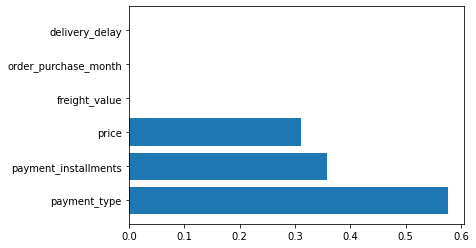

In [ ]:
plt.barh(y=p_values_df['feature_name'], width=p_values_df['p-value'])